In [1]:
%cd ~/cdv
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import numpy as np
import jax.numpy as jnp
import jax
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

import rho_plus as rp

is_dark = False
theme, cs = rp.mpl_setup(is_dark)
rp.plotly_setup(is_dark)

/home/nmiklaucic/miniconda3/envs/avid/lib/python3.12/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/nmiklaucic/miniconda3/envs/avid/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/nmiklaucic/cdv


In [2]:
from pathlib import Path
from facet.data.databatch import CrystalGraphs
from facet.layers import Context
import pyrallis
from facet.config import MainConfig
import orbax.checkpoint as ocp

from facet.training_state import TrainingRun
from facet.checkpointing import best_ckpt


conf_file = 'configs/sevennet.toml'

with open(conf_file) as f:
    config = pyrallis.cfgparsing.load(MainConfig, f)

from facet.data.dataset import load_file

config.data.dataset_name = 'mptrj'
cgs = []
for i in range(1):
    cgs.append(load_file(config, group_num=0, file_num=i))

cg: CrystalGraphs = sum(cgs[1:], start=cgs[0])

model = config.build_regressor()

params = model.init(jax.random.key(29205), cg=cg, ctx=Context(training=True))

param_size = sum(x.size for x in jax.tree.leaves(params))
param_size

842748

In [3]:
from facet.utils import load_pytree, debug_structure

ckpt = load_pytree('precomputed/sevennet.ckpt')
print(sum(x.size for x in jax.tree.leaves(ckpt)))
# debug_structure(ckpt);

842748


In [4]:
ctx = Context(training=False)
rng = jax.random.key(29205)
mod_ckpt = model.bind(ckpt)
out = mod_ckpt(cg=cg, ctx=ctx)
out.reshape(-1)


Array([ -7.8997455,  -6.8716917,  -5.9614024,  -4.2839947,  -5.184227 ,
        -8.966918 ,  -5.315304 ,  -7.450509 ,  -5.5380406,  -5.687567 ,
        -4.1991224,  -7.7113285,  -6.5472093,  -6.7260704,  -5.0813026,
        -7.1649313,  -5.8647666,  -6.548859 ,  -6.1808586,  -5.278281 ,
       -10.373532 ,  -4.054508 ,  -8.35315  ,  -5.239945 ,  -6.4754243,
        -3.6816647,  -7.073906 ,  -7.288776 ,  -9.82559  ,  -5.912794 ,
        -7.044846 ,   0.       ], dtype=float32)

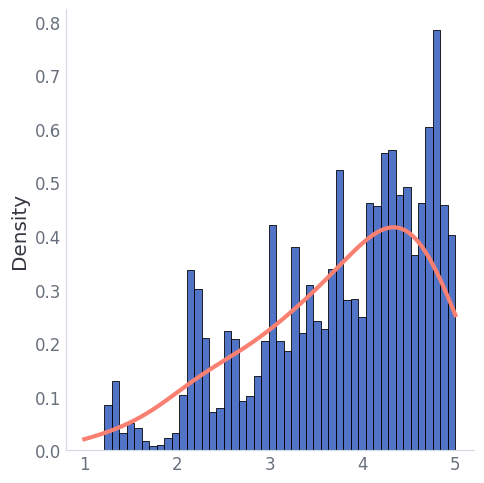

In [5]:
from facet.layers import dists

rmax = config.model.edge_embed.r_max

cg_dists = dists(cg)[cg.padding_mask[cg.nodes.graph_i]]
cg_dists = cg_dists.reshape(-1)
cg_dists = cg_dists[cg_dists < rmax]

sns.displot(cg_dists, stat='density')

num_samples = 8192

# rr = jnp.quantile(cg_dists, jnp.linspace(0, 1, num_samples))
# exact quantiles assumes this is perfectly predictive: instead, fuzz it a bit with a KDE

kde = jax.scipy.stats.gaussian_kde(cg_dists, 0.5)
dist_xx = jnp.linspace(1, 5, 1000)
dist_pdf = kde.evaluate(dist_xx)
plt.plot(dist_xx, dist_pdf, c='salmon', alpha=1, lw=3)

dist_cdf = jnp.cumsum(dist_pdf) / jnp.sum(dist_pdf)
rr = jnp.interp(jnp.linspace(0, 1, num_samples+2)[1:-1], dist_cdf, dist_xx)

In [6]:
from facet.mace.edge_embedding import BesselBasis, SincBasis

trim_params = jax.tree.map(lambda x: x, ckpt)

ckpt_basis = mod_ckpt.edge_embedding.basis
ckpt_bb = ckpt_basis(rr, rmax, ctx)
cutoff = mod_ckpt.edge_embedding.envelope(rr, rmax, ctx)[..., None]

num_basis = 8

num_new_freqs = num_basis - ckpt_basis.num_basis
# one approach: evenly distribute
# this may have overlap
new_freqs = jnp.quantile(ckpt_basis.freq, jnp.linspace(0, 1, num_new_freqs + 2)[1:-1])

# alternate approach: put frequencies between existing ones
# original frequencies are roughly equispaced
new_freqs = jnp.hstack([jnp.array([0]), ckpt_basis.freq])[:-1] + jnp.diff(ckpt_basis.freq, prepend=0) / 2
new_freqs = new_freqs[::-1][:num_new_freqs]

basis = BesselBasis(num_basis, True).bind({'params': {'freq': jnp.hstack((ckpt_basis.freq, new_freqs))}})
bb = basis(rr, rmax, ctx) * cutoff

trim_params['params']['edge_embedding']['basis']['freq'] = basis.freq

data = []

new_weights = []

r2s = []

for layer_i in range(5):
    w_mlp_params = ckpt['params']['mace'][f'layer_{layer_i}']['interaction']['SimpleInteraction_0']['SevenNetConv_0']['LazyInMLP_0']    
    w_mlp = mod_ckpt.mace.layers[layer_i].interaction.interaction.conv.radial_weight.copy(out_dim=w_mlp_params['Dense_2']['kernel'].shape[-1])

    ww = w_mlp.apply({'params': w_mlp_params}, rngs=rng, x=ckpt_bb, ctx=ctx) * cutoff
    # plt.plot(rr, ww, lw=0.3, alpha=0.2, c='grey')

    x, resid, rank, s = jnp.linalg.lstsq(bb, ww)
    ww_hat = bb @ x
    ww_err = (ww - ww_hat)
    r2 = 1 - (jnp.mean(jnp.square(ww_err)) / jnp.var(ww.reshape(-1))).item()
    r2s.append(r2)
    print(f'{r2:.2%}')
    mlp_trim = trim_params['params']['mace'][f'layer_{layer_i}']['interaction']['SimpleInteraction_0']['SevenNetConv_0']['LazyInMLP_0']
    for dense in list(mlp_trim.keys()):
        if dense.startswith('Dense_'):
            if dense == 'Dense_0':
                mlp_trim[dense]['kernel'] = x    
            else:
                del mlp_trim[dense]

    data.append({'mlp': ww, 'spline': ww_hat})

print('---------')
print(f'{np.mean(r2s):.2%}')

99.07%
99.66%
99.33%
99.30%
99.89%
---------
99.45%


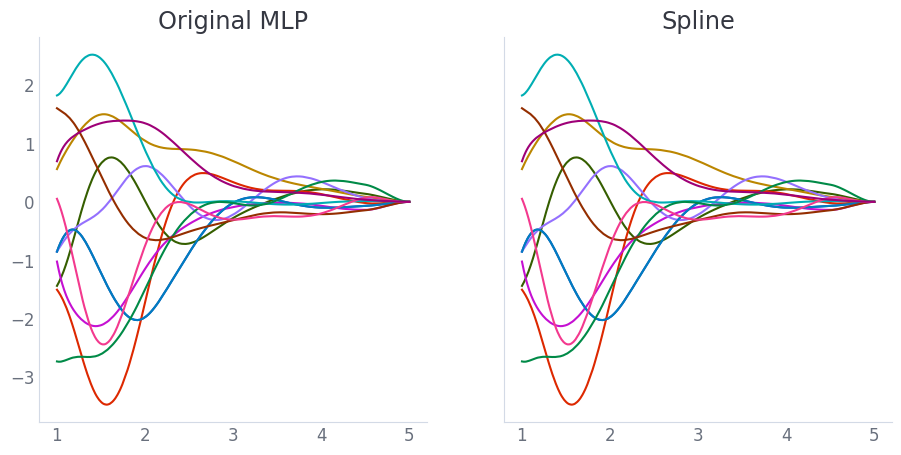

In [7]:
examples = np.random.default_rng(42).integers(0, ww.shape[1], size=12)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5), sharex=True, sharey=True)
ax1.set_title('Original MLP')
ax1.plot(rr, ww[:, examples])

ax2.set_title('Spline')
ax2.plot(rr, ww[:, examples]);

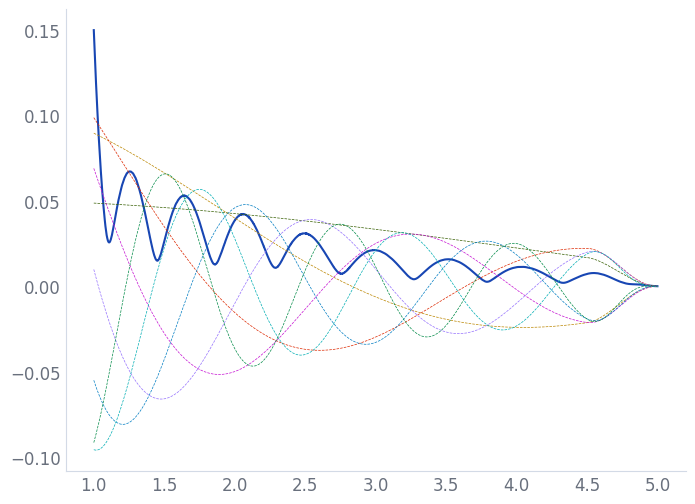

In [8]:
plt.plot(rr, jnp.sqrt(jnp.mean(jnp.square(ww_err), axis=1)))
plt.plot(rr, bb / 4, lw=0.5, ls='--');

In [9]:
np.save(f'data/sevennet_basis_{num_basis}.npy', {
    'cutoff': cutoff,
    'basis': ckpt_bb,
    'mlp': ww[:, examples],
    'spline': ww_hat[:, examples],
    'rr': rr,
})

In [10]:
from operator import add
print(jax.tree.reduce(add, jax.tree.map(lambda x: x.size, trim_params)))
print(jax.tree.reduce(add, jax.tree.map(lambda x: x.size, ckpt)))

624380
842748


In [13]:
mod_ckpt.mace.layers[0].interaction.interaction.conv


SevenNetConv(
    # attributes
    irreps_out = None
    avg_num_neighbors = None
    max_ell = 2
    radial_weight = LazyInMLP(
        # attributes
        inner_dims = (64, 64)
        out_dim = 0
        residual = False
        inner_act = normalized_silu
        final_act = Identity()
        dropout_rate = 0.0
        kernel_init = init
        bias_init = init
        normalization = 'Identity'
        use_bias = False
        # children
        final_act = Identity()
    )
    radial_power = 1
    # children
    radial_weight = LazyInMLP(
        # attributes
        inner_dims = (64, 64)
        out_dim = 0
        residual = False
        inner_act = normalized_silu
        final_act = Identity()
        dropout_rate = 0.0
        kernel_init = init
        bias_init = init
        normalization = 'Identity'
        use_bias = False
        # children
        final_act = Identity()
    )
)

In [23]:
import e3nn_jax as e3nn
from e3nn_jax.legacy import FunctionalTensorProduct
from facet.mace.e3_layers import E3Irreps
import functools as ft
import operator

ir_out = E3Irreps('1x0e + 1x1e + 1x2e')

N = 96
E = 32
edge_sh = e3nn.zeros('1x0e + 1x1e + 1x2e', leading_shape=(N, E))

# map node features onto edges for tp
node_feats = e3nn.zeros('128x0e + 64x1e + 32x2e', leading_shape=(N,))
edge_features = node_feats # [n_nodes, irreps]

# we gather the instructions for the tp as well as the tp output irreps
mode = 'uvu'
trainable = True
irreps_after_tp = []
instructions = []

# iterate over both arguments, i.e. node irreps and edge irreps
# if they have a valid TP path for any of the target irreps,
# add to instructions and put in appropriate position
# we use uvu mode (where v is a single-element sum) and weights will
# be provide externally by the scalar MLP
# this triple for loop is similar to the one used in e3nn and nequip
for i, (mul_in1, irreps_in1) in enumerate(node_feats.irreps):
    for j, (_, irreps_in2) in enumerate(edge_sh.irreps):
        for curr_irreps_out in irreps_in1 * irreps_in2:
            if curr_irreps_out in ir_out:
                k = len(irreps_after_tp)
                irreps_after_tp += [(mul_in1, curr_irreps_out)]
                instructions += [(i, j, k, mode, trainable)]

# we will likely have constructed irreps in a non-l-increasing order
# so we sort them to be in a l-increasing order
irreps_after_tp, p, _inv = E3Irreps(irreps_after_tp).sort()

# if we sort the target irreps, we will have to sort the instructions
# acoordingly, using the permutation indices
sorted_instructions = []

for irreps_in1, irreps_in2, irreps_out, mode, trainable in instructions:
    sorted_instructions += [
        (
            irreps_in1,
            irreps_in2,
            p[irreps_out],
            mode,
            trainable,
        )
    ]

# print(sorted_instructions)

# TP between spherical harmonics embedding of the edge vector
# Y_ij(\hat{r}) and neighboring node h_j, weighted on a per-element basis
# by the radial network R(r_ij)
tp = FunctionalTensorProduct(
    irreps_in1=edge_features.irreps,
    irreps_in2=edge_sh.irreps,
    irreps_out=irreps_after_tp,
    instructions=sorted_instructions,
)


for ins in tp.instructions:
    if ins.i_in2 == 0:  # multiplied by 0e which is 1
        ins.output_multiplicity

128

In [12]:
from facet.utils import save_pytree


save_pytree(trim_params, f'precomputed/sevennet-trimmed-emb{num_basis}.ckpt')

In [13]:
trim2_params = jax.tree.map(lambda x: x, trim_params)

w1 = trim2_params['params']['head']['Dense_0']['kernel']
w2 = trim2_params['params']['head']['Dense_1']['kernel']

w12 = w1 @ w2

del trim2_params['params']['head']['Dense_1']

trim2_params['params']['head']['Dense_0']['kernel'] = w12

save_pytree(trim2_params, f'precomputed/sevennet-trimmed-emb{num_basis}-linhead.ckpt')

In [16]:
from facet.utils import debug_stat


debug_stat(trim2_params);

arg0 >>> params
├── edge_embedding >>> basis >>> freq
│   └──     (   0.508     1.11     2.38     3.72     5.12)     2.75 ±     1.51
├── head >>> Dense_0 >>> kernel
│   └──     (   -2.27   -0.391   0.0175    0.251     3.17) -0.00737 ±    0.743 E-2
├── mace
│   ├── layer_0 >>> interaction
│   │   ├── SimpleInteraction_0
│   │   │   ├── SevenNetConv_0 >>> LazyInMLP_0 >>> Dense_0 >>> kernel
│   │   │   │   └──     (   -26.7    -3.56   0.0795     3.69     25.4) -0.00236 ±     6.01
│   │   │   ├── linear_intro >>> w[0,0] 128x0e,128x0e
│   │   │   │   └──     (   -6.91    -1.11  -0.0237     1.07     7.22)  -0.0175 ±     1.66~
│   │   │   └── linear_outro
│   │   │       ├── w[0,0] 128x0e,224x0e
│   │   │       │   └──     (   -10.3    -1.32  -0.0243      1.3     9.72)  -0.0155 ±     2.06~
│   │   │       ├── w[1,1] 128x1e,64x1e
│   │   │       │   └──     (   -9.23    -1.39  -0.0084      1.4     8.04)   0.0045 ±     2.14
│   │   │       └── w[2,2] 128x2e,32x2e
│   │   │           └──     (   -7.35    -1.31  0.00135     1.35     8.22)   0.0109 ±     1.99
│   │   └── resid_adapter >>> w[0,0] 128x0e,224x0e
│   │       └──     (   -8.91    -1.14    0.023     1.15     8.44)   0.0145 ±     1.75~
│   ├── layer_1 >>> interaction
│   │   ├── SimpleInteraction_0
│   │   │   ├── SevenNetConv_0 >>> LazyInMLP_0 >>> Dense_0 >>> kernel
│   │   │   │   └──     (   -32.5    -3.09  -0.0262     3.19     30.1)   0.0826 ±     6.59
│   │   │   ├── linear_intro
│   │   │   │   ├── w[0,0] 128x0e,128x0e
│   │   │   │   │   └──     (   -8.75    -1.21  0.00615     1.22     8.38) -0.000617 ±     1.84~
│   │   │   │   ├── w[1,1] 64x1e,64x1e
│   │   │   │   │   └──     (   -9.48    -1.73  -0.0219     1.73     10.7) -0.00267 ±     2.64
│   │   │   │   └── w[2,2] 32x2e,32x2e
│   │   │   │       └──     (   -8.54    -1.73   -0.105     1.75     8.36)   0.0491 ±     2.58
│   │   │   └── linear_outro
│   │   │       ├── w[0,0] 224x0e,224x0e
│   │   │       │   └──     (     -14    -1.46  -0.0123     1.46       13) -0.00246 ±     2.29~
│   │   │       ├── w[1,1] 384x1e,64x1e
│   │   │       │   └──     (   -11.3    -1.21 -0.00243     1.22      9.9) -0.00221 ±     2.12~
│   │   │       └── w[2,2] 352x2e,32x2e
│   │   │           └──     (   -10.7     -1.2  -0.0122     1.18     9.02) -0.00038 ±     2.13~
│   │   └── resid_adapter
│   │       ├── w[0,0] 128x0e,224x0e
│   │       │   └──     (   -7.07    -1.11  0.00346     1.07      6.6)  -0.0201 ±     1.66~
│   │       ├── w[1,1] 64x1e,64x1e
│   │       │   └──     (   -7.46    -1.33  -0.0462     1.23     7.85)  -0.0268 ±     1.97
│   │       └── w[2,2] 32x2e,32x2e
│   │           └──     (   -6.05    -1.13    0.048     1.13     7.12)   0.0326 ±     1.74
│   ├── layer_2 >>> interaction
│   │   ├── SimpleInteraction_0
│   │   │   ├── SevenNetConv_0 >>> LazyInMLP_0 >>> Dense_0 >>> kernel
│   │   │   │   └──     (   -28.9    -2.57    0.168     2.99     24.9)    0.186 ±     5.43
│   │   │   ├── linear_intro
│   │   │   │   ├── w[0,0] 128x0e,128x0e
│   │   │   │   │   └──     (   -7.76    -1.39  -0.0408     1.32     8.92)  -0.0238 ±     2.06~
│   │   │   │   ├── w[1,1] 64x1e,64x1e
│   │   │   │   │   └──     (   -8.28    -1.77  -0.0371      1.8     9.74)  0.00515 ±      2.7
│   │   │   │   └── w[2,2] 32x2e,32x2e
│   │   │   │       └──     (   -7.79    -1.92  -0.0489     1.83     8.69)   0.0161 ±     2.73
│   │   │   └── linear_outro
│   │   │       ├── w[0,0] 224x0e,224x0e
│   │   │       │   └──     (   -11.9    -1.54 -0.00544     1.53     13.5) -0.00842 ±     2.41~
│   │   │       ├── w[1,1] 384x1e,64x1e
│   │   │       │   └──     (   -10.9    -1.26  0.00123     1.28     9.08) -0.00267 ±      2.2~
│   │   │       └── w[2,2] 352x2e,32x2e
│   │   │           └──     (   -10.1     -1.2 -0.00367     1.23     9.75)  0.00299 ±     2.19~
│   │   └── resid_adapter
│   │       ├── w[0,0] 128x0e,224x0e
│   │       │   └──     (   -8.52    -1.18  -0.0551     1.03     11.8)  -0.0979 ±     1.72~
│   │       ├── w[1,1] 64x1e,64x1e
│   │